<a href="https://colab.research.google.com/github/fyprjgroup3/FY_project/blob/avik's_work/Labelizer_nbv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import re
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
import collections
nltk.download('stopwords')

from google.colab import drive
from google.colab import files
#import io
#uploaded = files.upload()

drive.mount('/content/drive') # mounting drive in each runtime

pd.set_option("display.max_columns",2500)
pd.set_option("display.max_rows",2500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing the dataset
dset=pd.read_csv('/content/drive/My Drive/FY_project/dataset/results-20190513-ofapr19.csv')
dset.head()

,action,url,title,body,labels
0,"""closed""","""https://github.com/Microsoft/vcpkg/issues/4548""","""Error: Building package zlib:x64-windows-stat...","""\r\nPackage: zlib:x64-windows-static\r\nVcpkg...","[{""id"":455857191,""node_id"":""MDU6TGFiZWw0NTU4NT..."
1,"""closed""","""https://github.com/primefaces/primeng/issues/...","""Pagination bug when removing an item""","""Reported by a PRO user;\r\n\r\n> If for exemp...","[{""id"":312160661,""node_id"":""MDU6TGFiZWwzMTIxNj..."
2,"""closed""","""https://github.com/zen-kernel/zen-kernel/issu...","""bfq error""","""Hi, Steven/\r\nAfter last update today >git f...",[]
3,"""closed""","""https://github.com/biig-io/ngx-smart-modal/is...","""Can't open next modal at once after closing p...","""\r\nwhen I click immediately after closing pr...",[]
4,"""closed""","""https://github.com/istio/istio/issues/12790""","""Helm podAntiAffinity templating error""","""**Describe the bug**\r\n\r\nHelm charts fail ...","[{""id"":670442116,""node_id"":""MDU6TGFiZWw2NzA0ND..."


In [4]:
#No of rows initially
print("No. of Rows:",end=" ")
dset.shape[0]

No. of Rows: 

7964

In [5]:
# Removing Duplicates if any in the dataset
print('The no. of duplicates in the data are',dset.duplicated().sum())

The no. of duplicates in the data are 3


In [0]:
dset.drop_duplicates(inplace=True)

In [7]:
dset.shape

(7961, 5)

In [8]:
# selecting necessary features
prc_dset=dset[["title","body","labels"]]
prc_dset.head()

,title,body,labels
0,"""Error: Building package zlib:x64-windows-stat...","""\r\nPackage: zlib:x64-windows-static\r\nVcpkg...","[{""id"":455857191,""node_id"":""MDU6TGFiZWw0NTU4NT..."
1,"""Pagination bug when removing an item""","""Reported by a PRO user;\r\n\r\n> If for exemp...","[{""id"":312160661,""node_id"":""MDU6TGFiZWwzMTIxNj..."
2,"""bfq error""","""Hi, Steven/\r\nAfter last update today >git f...",[]
3,"""Can't open next modal at once after closing p...","""\r\nwhen I click immediately after closing pr...",[]
4,"""Helm podAntiAffinity templating error""","""**Describe the bug**\r\n\r\nHelm charts fail ...","[{""id"":670442116,""node_id"":""MDU6TGFiZWw2NzA0ND..."


In [9]:
# Removing empty label rows
def clean(s):
  '''
  Sets Empty labels as NaNs
  '''
  
  if s == "[]":
    s=np.nan
  return s
    
prc_dset['labels']=prc_dset['labels'].apply(lambda x: clean(x))
prc_dset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,title,body,labels
0,"""Error: Building package zlib:x64-windows-stat...","""\r\nPackage: zlib:x64-windows-static\r\nVcpkg...","[{""id"":455857191,""node_id"":""MDU6TGFiZWw0NTU4NT..."
1,"""Pagination bug when removing an item""","""Reported by a PRO user;\r\n\r\n> If for exemp...","[{""id"":312160661,""node_id"":""MDU6TGFiZWwzMTIxNj..."
2,"""bfq error""","""Hi, Steven/\r\nAfter last update today >git f...",NaN
3,"""Can't open next modal at once after closing p...","""\r\nwhen I click immediately after closing pr...",NaN
4,"""Helm podAntiAffinity templating error""","""**Describe the bug**\r\n\r\nHelm charts fail ...","[{""id"":670442116,""node_id"":""MDU6TGFiZWw2NzA0ND..."
...,...,...,...
7959,"""Finer audio controls in Tangent""","""Mike Lunt writes:\r\n\r\n> **What feature wou...","[{""id"":487891729,""node_id"":""MDU6TGFiZWw0ODc4OT..."
7960,"""Composer auth (for https) is not being saved""","""Everytime you reboot the docker images the au...","[{""id"":991880776,""node_id"":""MDU6TGFiZWw5OTE4OD..."
7961,"""Slide macro""","""Based on the work here: https://github.com/th...","[{""id"":1166794637,""node_id"":""MDU6TGFiZWwxMTY2N..."
7962,"""How to see the real change after using LFS :-)""","""Dear folks\r\n\r\nIt's not really an issue (r...",NaN


In [10]:
prc_dset.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
prc_dset.head()

,title,body,labels
0,"""Error: Building package zlib:x64-windows-stat...","""\r\nPackage: zlib:x64-windows-static\r\nVcpkg...","[{""id"":455857191,""node_id"":""MDU6TGFiZWw0NTU4NT..."
1,"""Pagination bug when removing an item""","""Reported by a PRO user;\r\n\r\n> If for exemp...","[{""id"":312160661,""node_id"":""MDU6TGFiZWwzMTIxNj..."
4,"""Helm podAntiAffinity templating error""","""**Describe the bug**\r\n\r\nHelm charts fail ...","[{""id"":670442116,""node_id"":""MDU6TGFiZWw2NzA0ND..."
5,"""[0.5][Tradingview] Quick Chart resize does no...","""**Describe the bug**\r\nThe up and down arrow...","[{""id"":1089646255,""node_id"":""MDU6TGFiZWwxMDg5N..."
6,"""Upgrade isort""","""We are using 4.3.4 but [isort[(https://pypi.o...","[{""id"":717069763,""node_id"":""MDU6TGFiZWw3MTcwNj..."


In [12]:
print("No. rows after null label rows removed:",end=" ")
prc_dset.shape[0]

No. rows after null label rows removed: 

4063

In [13]:
# checking the format of labels
prc_dset['labels'][5]

'[{"id":1089646255,"node_id":"MDU6TGFiZWwxMDg5NjQ2MjU1","url":"https://api.github.com/repos/bitshares/bitshares-ui/labels/[1b]%20User%20Story","name":"[1b] User Story","color":"b8e4fc","default":false},{"id":272058720,"node_id":"MDU6TGFiZWwyNzIwNTg3MjA=","url":"https://api.github.com/repos/bitshares/bitshares-ui/labels/[3]%20Bug","name":"[3] Bug","color":"b60205","default":false},{"id":522016380,"node_id":"MDU6TGFiZWw1MjIwMTYzODA=","url":"https://api.github.com/repos/bitshares/bitshares-ui/labels/[4c]%20High%20Priority","name":"[4c] High Priority","color":"fbca04","default":false},{"id":1089668332,"node_id":"MDU6TGFiZWwxMDg5NjY4MzMy","url":"https://api.github.com/repos/bitshares/bitshares-ui/labels/[5a]%20Tiny","name":"[5a] Tiny","color":"f9aed0","default":false},{"id":1133046734,"node_id":"MDU6TGFiZWwxMTMzMDQ2NzM0","url":"https://api.github.com/repos/bitshares/bitshares-ui/labels/[6]%20RC%20Blockage","name":"[6] RC Blockage","color":"0052cc","default":false},{"id":1134524965,"node_id"

In [14]:
#since labels are of string type converting it into list of dictionaries
json.loads(prc_dset['labels'][5])

[{'color': 'b8e4fc',
  'default': False,
  'id': 1089646255,
  'name': '[1b] User Story',
  'node_id': 'MDU6TGFiZWwxMDg5NjQ2MjU1',
  'url': 'https://api.github.com/repos/bitshares/bitshares-ui/labels/[1b]%20User%20Story'},
 {'color': 'b60205',
  'default': False,
  'id': 272058720,
  'name': '[3] Bug',
  'node_id': 'MDU6TGFiZWwyNzIwNTg3MjA=',
  'url': 'https://api.github.com/repos/bitshares/bitshares-ui/labels/[3]%20Bug'},
 {'color': 'fbca04',
  'default': False,
  'id': 522016380,
  'name': '[4c] High Priority',
  'node_id': 'MDU6TGFiZWw1MjIwMTYzODA=',
  'url': 'https://api.github.com/repos/bitshares/bitshares-ui/labels/[4c]%20High%20Priority'},
 {'color': 'f9aed0',
  'default': False,
  'id': 1089668332,
  'name': '[5a] Tiny',
  'node_id': 'MDU6TGFiZWwxMDg5NjY4MzMy',
  'url': 'https://api.github.com/repos/bitshares/bitshares-ui/labels/[5a]%20Tiny'},
 {'color': '0052cc',
  'default': False,
  'id': 1133046734,
  'name': '[6] RC Blockage',
  'node_id': 'MDU6TGFiZWwxMTMzMDQ2NzM0',
  'ur

In [15]:
#To extract only name field from labels
[x['name'] for x in json.loads(prc_dset['labels'][5])]

['[1b] User Story',
 '[3] Bug',
 '[4c] High Priority',
 '[5a] Tiny',
 '[6] RC Blockage',
 '[7] Estimated']

In [16]:
#Converting names of labels into list of lists
labels=[]

for i in prc_dset['labels']:
  labels.append([x['name'] for x in json.loads(i)])

labels[:10]

[['needs-repro'],
 ['enhancement'],
 ['area/environments'],
 ['[1b] User Story',
  '[3] Bug',
  '[4c] High Priority',
  '[5a] Tiny',
  '[6] RC Blockage',
  '[7] Estimated'],
 ['feature-refactoring', 'good first issue', 'needs PR', 'type-code health'],
 ['feature'],
 ['Feature:Search', 'Feature:Telemetry', 'P1', 'a-c'],
 ['A-partitioning', 'A-sql-syntax', 'C-enhancement'],
 ['enhancement', 'priority:low'],
 ['ApiTestUat']]

In [17]:
#merging processed labels into the dataset
prc_dset['labels']=labels
prc_dset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,title,body,labels
0,"""Error: Building package zlib:x64-windows-stat...","""\r\nPackage: zlib:x64-windows-static\r\nVcpkg...",[needs-repro]
1,"""Pagination bug when removing an item""","""Reported by a PRO user;\r\n\r\n> If for exemp...",[enhancement]
4,"""Helm podAntiAffinity templating error""","""**Describe the bug**\r\n\r\nHelm charts fail ...",[area/environments]
5,"""[0.5][Tradingview] Quick Chart resize does no...","""**Describe the bug**\r\nThe up and down arrow...","[[1b] User Story, [3] Bug, [4c] High Priority,..."
6,"""Upgrade isort""","""We are using 4.3.4 but [isort[(https://pypi.o...","[feature-refactoring, good first issue, needs ..."
...,...,...,...
7957,"""review all the URI endpoints to make them coh...","""""",[in progress]
7959,"""Finer audio controls in Tangent""","""Mike Lunt writes:\r\n\r\n> **What feature wou...",[enhancement]
7960,"""Composer auth (for https) is not being saved""","""Everytime you reboot the docker images the au...",[enhancement]
7961,"""Slide macro""","""Based on the work here: https://github.com/th...","[state_verification, type_feature]"


In [0]:
stopwords = nltk.corpus.stopwords.words('english')

In [19]:
print(len(stopwords))

179


In [20]:
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
# function for text cleaning 
def clean_text(s):
    s=re.sub("[\'\"]","",s) #remove '' and ""
    s=re.sub("\\\\r","",s)  #remove \r
    s=re.sub("\\\\n","",s)  #remove \n
    s=re.sub("[^a-zA-Z]"," ",s) #remove everything but letters
    s=''.join([char for char in s if char not in string.punctuation]) #remove all punctuations
    #l=[word.lower() for word in s.split() if not word.lower() in stopword]  #remove stopwords
    s = ' '.join(s.split()) # remove whitespaces 
    s = s.lower()# convert text to lowercase 

    return s


In [23]:
# cleaning of title and body fields
prc_dset['title'] = prc_dset['title'].apply(lambda x: clean_text(x))
prc_dset['body'] = prc_dset['body'].apply(lambda x: clean_text(x))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
#Cleaned labels and body fields
prc_dset.head(10)

,title,body,labels
0,error building package zlib x windows static f...,package zlib x windows staticvcpkg version debug,[needs-repro]
1,pagination bug when removing an item,reported by a pro user if for exemple we have ...,[enhancement]
4,helm podantiaffinity templating error,describe the bug helm charts fail to generate ...,[area/environments]
5,tradingview quick chart resize does not honor ...,describe the bug the up and down arrows for tr...,"[[1b] User Story, [3] Bug, [4c] High Priority,..."
6,upgrade isort,we are using but isort https pypi org project ...,"[feature-refactoring, good first issue, needs ..."
7,configurable window of completion,from not fixed the window for completion of a ...,[feature]
8,telemetry add search counts to baseline ping,follow up on https github com mozilla mobile f...,"[Feature:Search, Feature:Telemetry, P1, a-c]"
9,sql show zone configuration for table table na...,describe the problem i partitioned a table cre...,"[A-partitioning, A-sql-syntax, C-enhancement]"
12,add ice and snow melt flag general flag category,could be useful in some cases,"[enhancement, priority:low]"
13,vulnerability ddos get api v projects,project apitestuattemplate apiv projectsgetque...,[ApiTestUat]


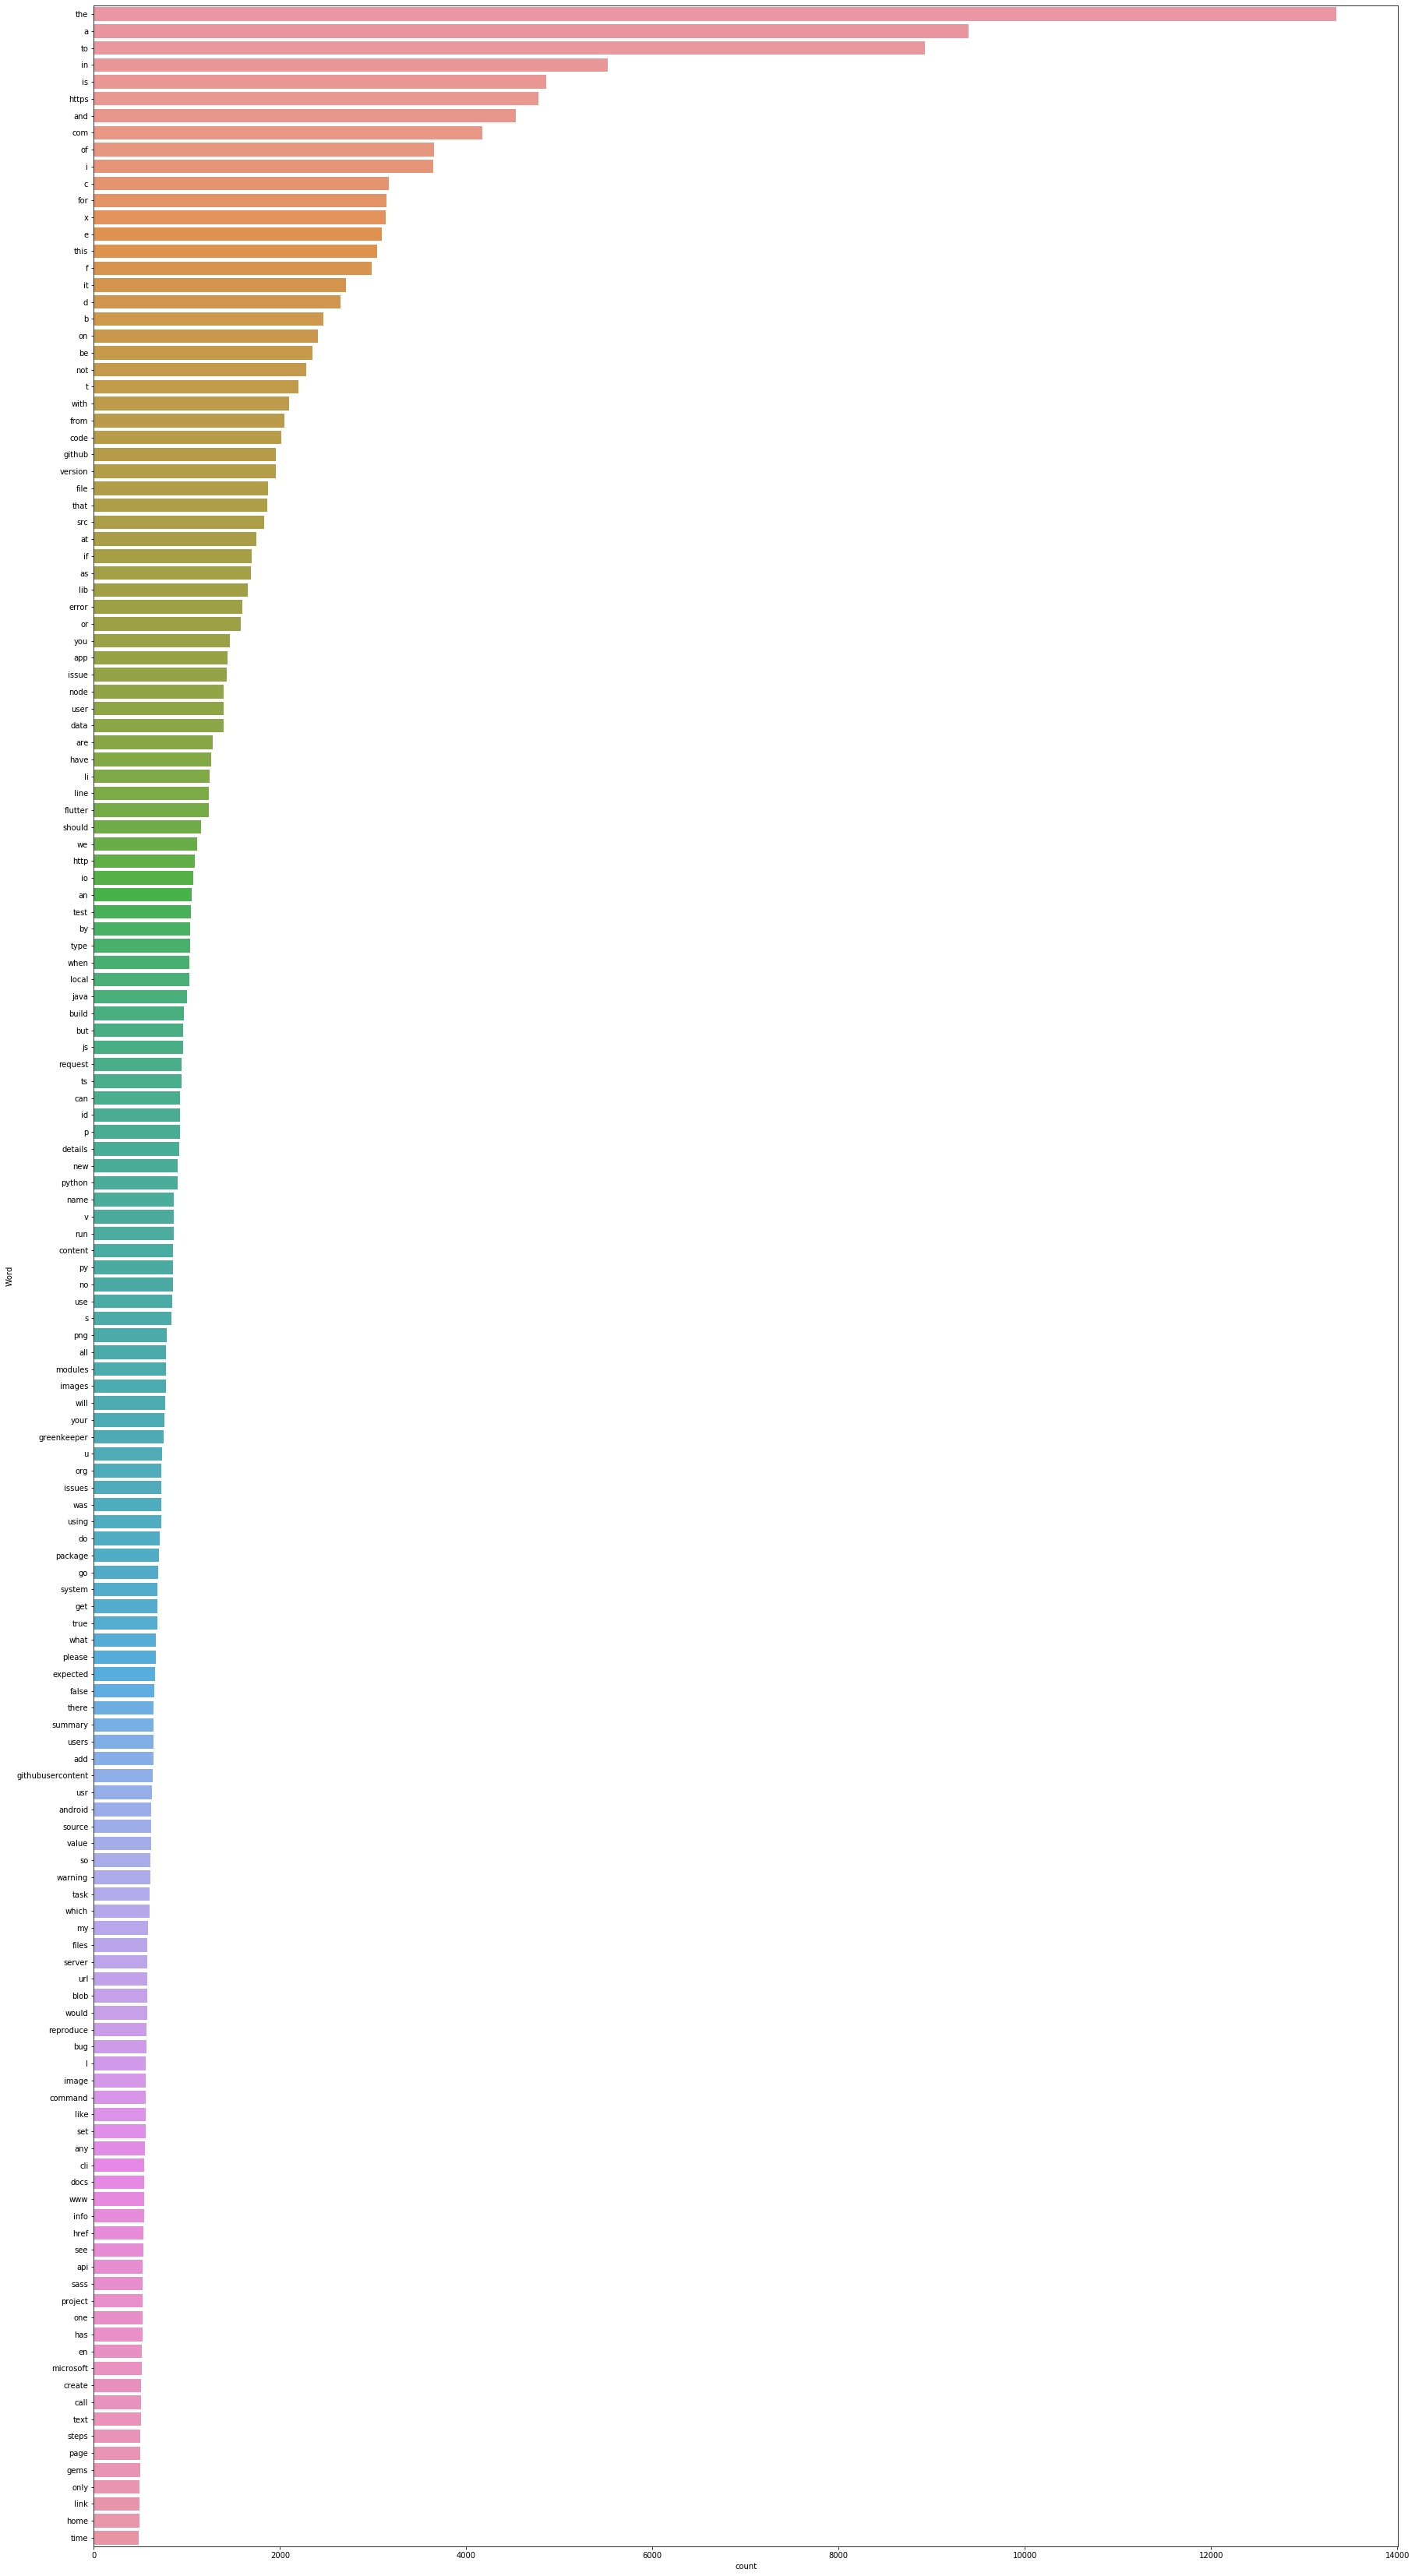

In [25]:
#find out the most frequent words in the title and body
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top n most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(30,60)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 150 most frequent words 
freq_words(prc_dset['body'], 150)
# Denotes many stopwords are present in title and body

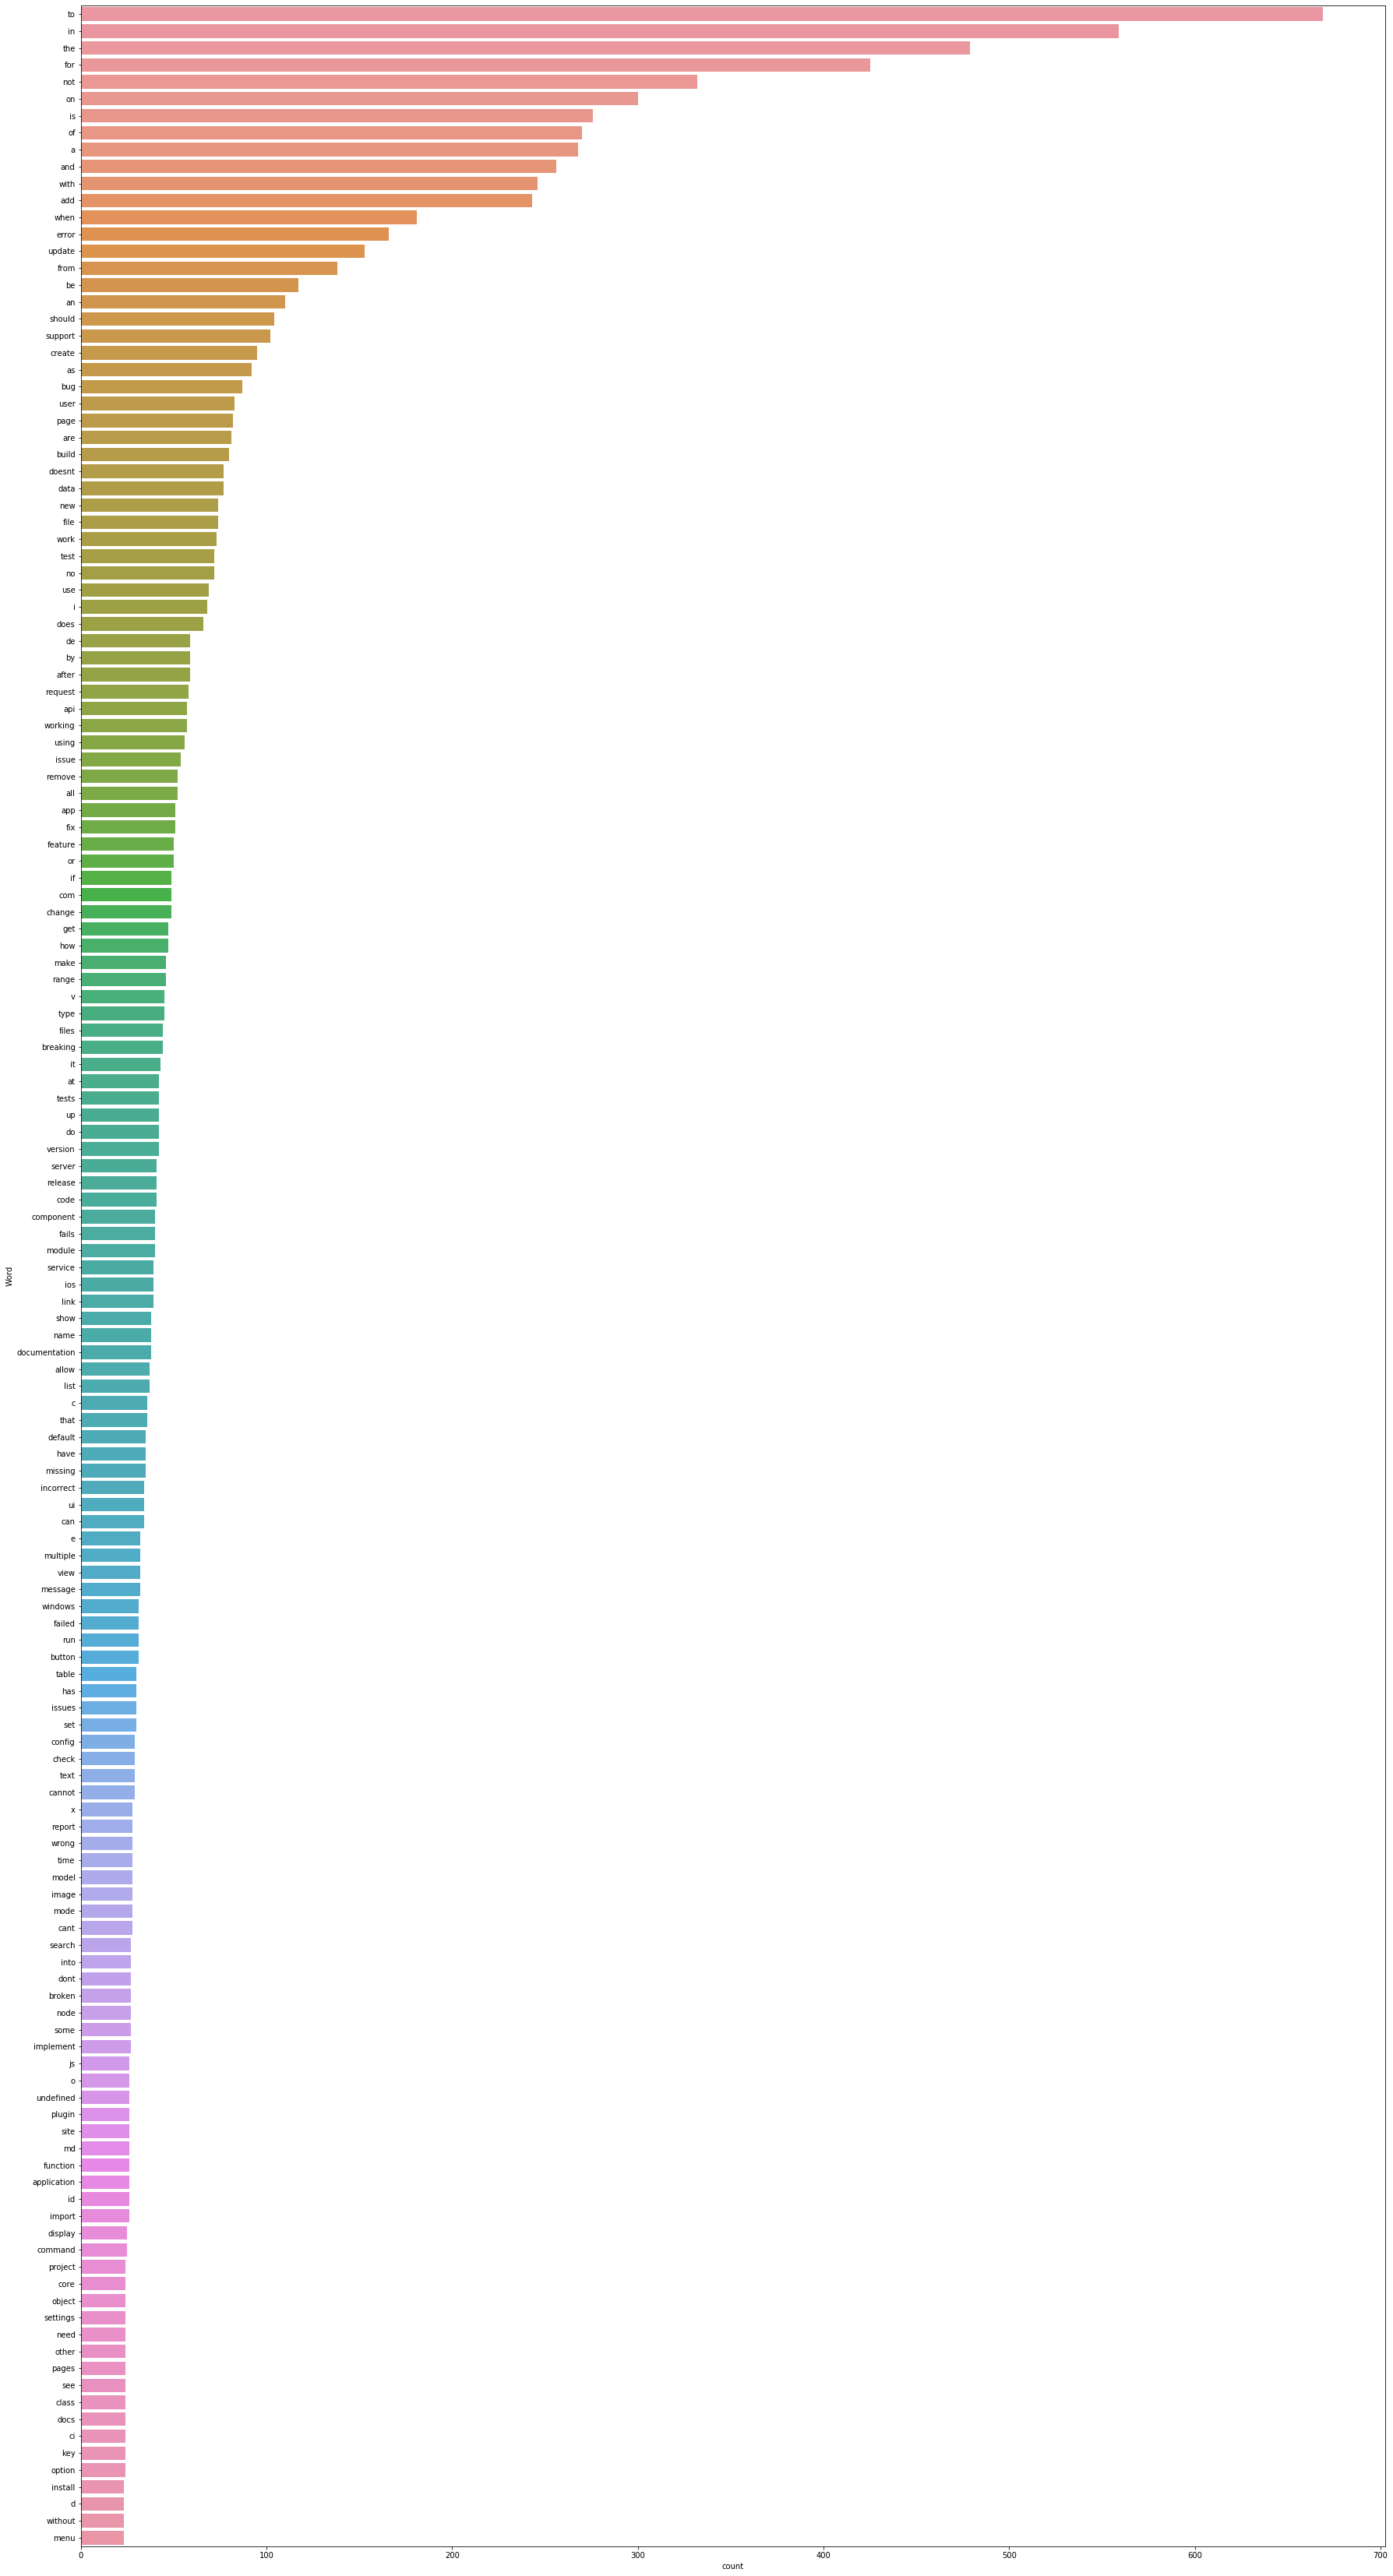

In [26]:
freq_words(prc_dset['title'], 150)

In [0]:
# Along with common english stopwords few others are present as noise in the data
newStopWords = ['www','com','r','n','c','e','f','b','g','h','l','http','https','u','v','x','z','de','non','rb','ef','li','ts','p','md','ci','go','cli','en','ms','br','sdm','us','k','cc','eslint','tat','im','fbadb','cccfb','dali']
# Extended list of pre-defined nltk stopwords with some redundant words
stopwords.extend(newStopWords)

In [28]:
#function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return ' '.join(no_stopword_text)

#removing stopwords from title and body
prc_dset['title'] = prc_dset['title'].apply(lambda x: remove_stopwords(x))
prc_dset['body'] = prc_dset['body'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


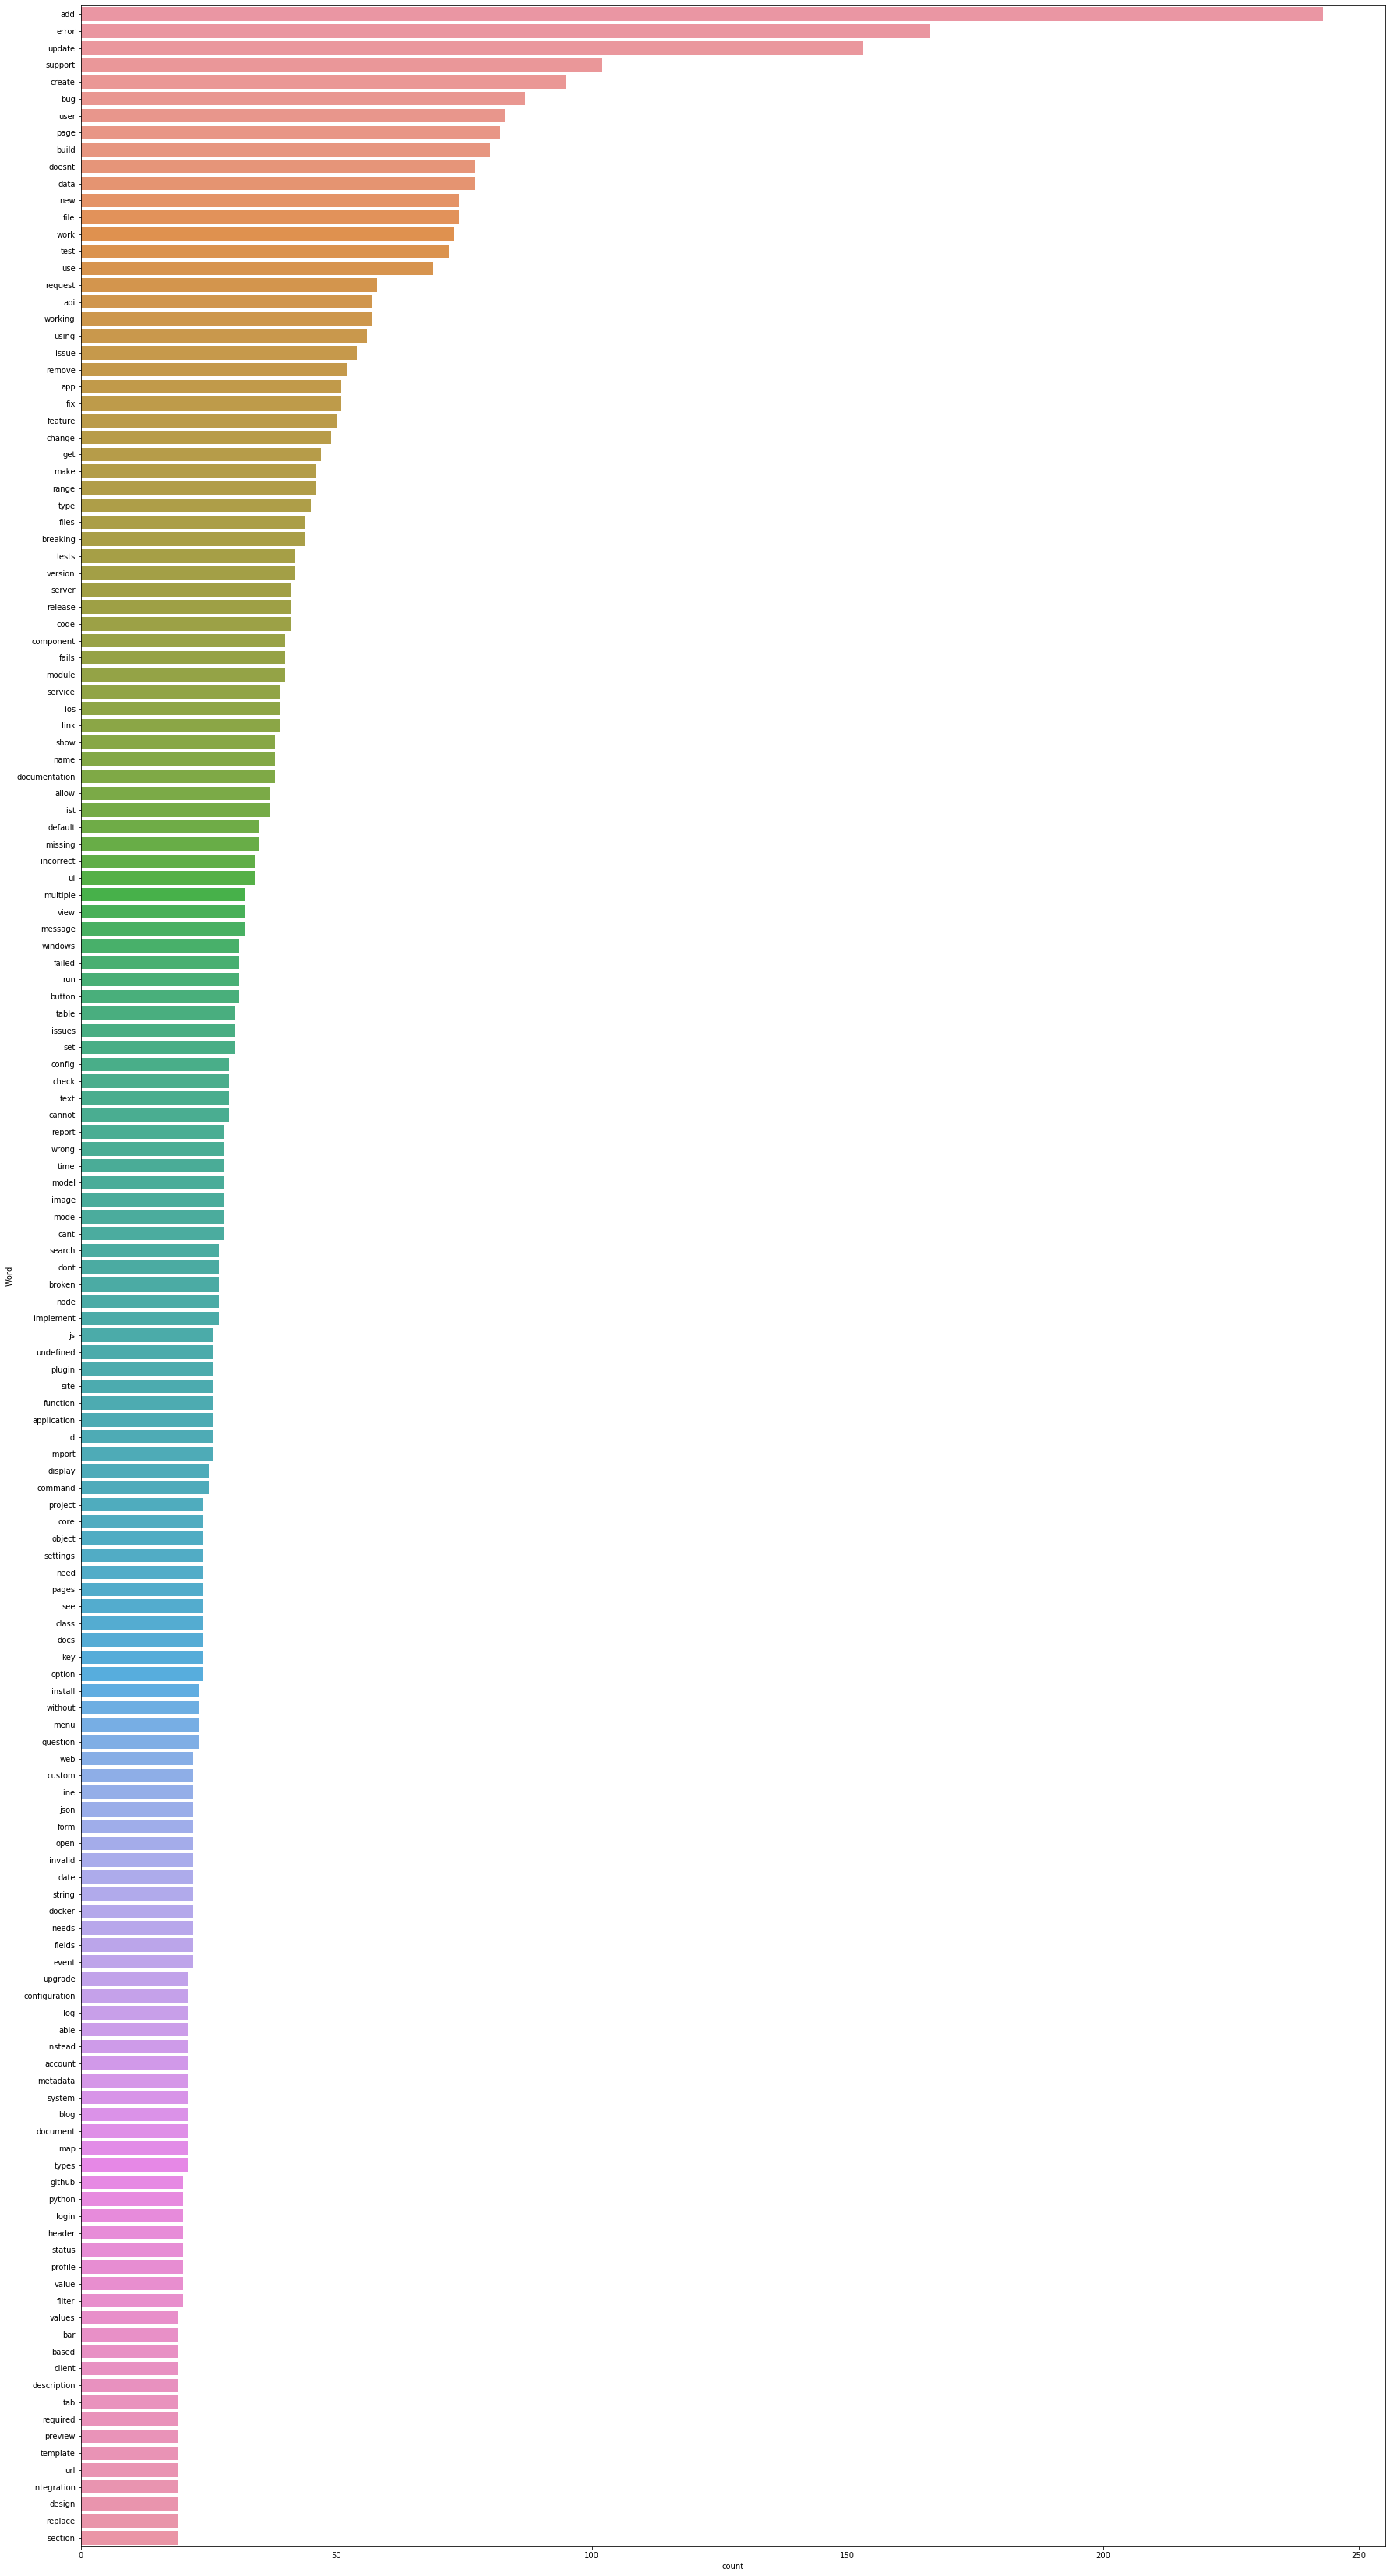

In [29]:
#Frequency of common words now showing some relevant words
freq_words(prc_dset['title'], 150)

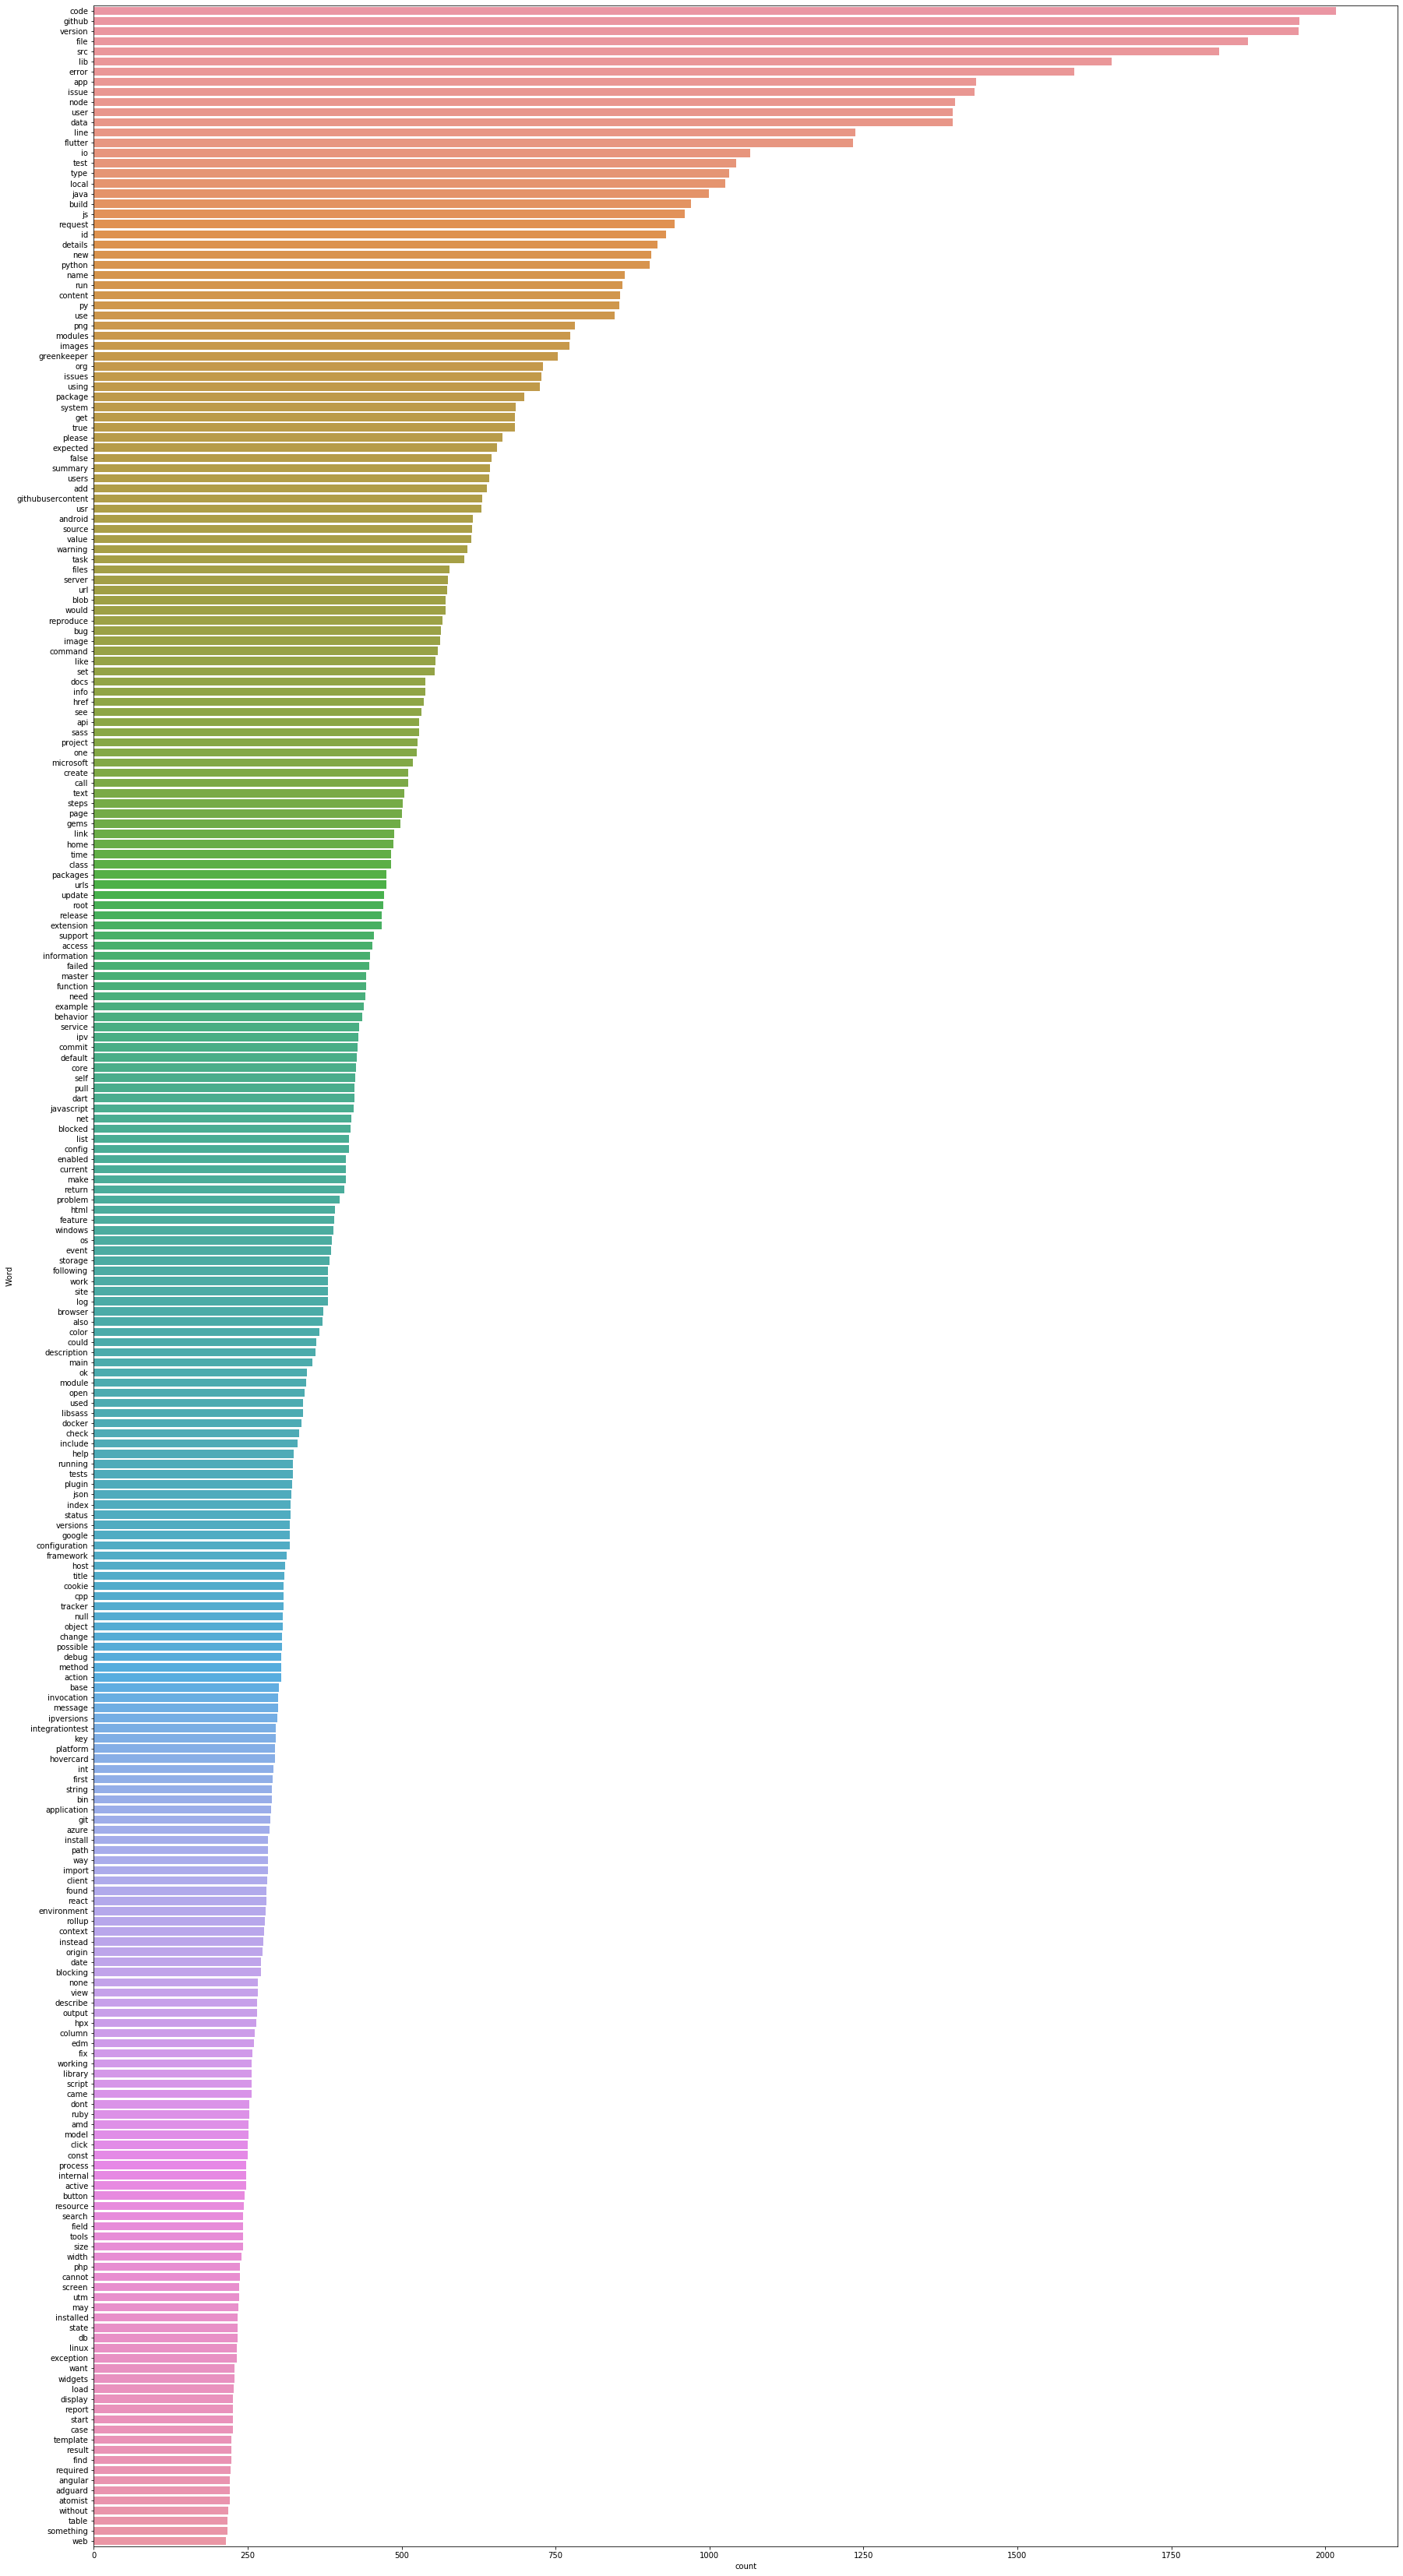

In [30]:
freq_words(prc_dset['body'], 250)

In [31]:
#cleaned dataset
prc_dset.head(10)

,title,body,labels
0,error building package zlib windows static fai...,package zlib windows staticvcpkg version debug,[needs-repro]
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement]
4,helm podantiaffinity templating error,describe bug helm charts fail generate proper ...,[area/environments]
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[[1b] User Story, [3] Bug, [4c] High Priority,..."
6,upgrade isort,using isort pypi org project isort latest migh...,"[feature-refactoring, good first issue, needs ..."
7,configurable window completion,fixed window completion given questionnaire co...,[feature]
8,telemetry add search counts baseline ping,follow github mozilla mobile fenix issues issu...,"[Feature:Search, Feature:Telemetry, P1, a-c]"
9,sql show zone configuration table table name p...,describe problem partitioned table created rep...,"[A-partitioning, A-sql-syntax, C-enhancement]"
12,add ice snow melt flag general flag category,could useful cases,"[enhancement, priority:low]"
13,vulnerability ddos get api projects,project apitestuattemplate apiv projectsgetque...,[ApiTestUat]


In [0]:
#Merging all labels in a single list
labels=[]
for i in prc_dset['labels']:
    labels.extend(i)

In [33]:
#Merged list of all labels
labels[:10]

['needs-repro',
 'enhancement',
 'area/environments',
 '[1b] User Story',
 '[3] Bug',
 '[4c] High Priority',
 '[5a] Tiny',
 '[6] RC Blockage',
 '[7] Estimated',
 'feature-refactoring']

In [0]:
#Counting frequency of the labels
count={}
for x in labels:
    if x not in count:
        count[x]=1
    else:
        count[x]+=1
d = collections.Counter(count)
freq=[]
i=0
for w,c in d.most_common(2502):
    freq.append([w,c])

In [35]:
#1st 50 frequent labels
freq[:50]

[['bug', 673],
 ['enhancement', 586],
 ['question', 147],
 ['help wanted', 104],
 ['good first issue', 87],
 ['wontfix', 72],
 ['feature', 67],
 ['Bug', 55],
 ['stale', 48],
 ['greenkeeper', 47],
 ['in progress', 39],
 ['triaged', 38],
 ['type: bug', 33],
 ['documentation', 31],
 ['duplicate', 30],
 ['kind/bug', 28],
 ['task', 26],
 ['invalid', 26],
 ['user-submission', 25],
 ['assigned-to-author', 23],
 ['review', 21],
 ['docs', 20],
 ['Enhancement', 20],
 ['N: AdGuard Browser Extension', 18],
 ['feature request', 18],
 ['P3: Medium', 17],
 ['browser-firefox', 17],
 ['P1', 15],
 ['Priority: High', 15],
 ['Priority: Medium', 15],
 ['frontend', 15],
 ['support', 14],
 ['design', 14],
 ['Epic', 14],
 ['new-version', 14],
 ['cxp', 14],
 ['browser-firefox-mobile', 14],
 ['ui', 13],
 ['Feature', 13],
 ['high priority', 13],
 ['triage', 13],
 ['discussion', 12],
 ['priority/P0', 12],
 ['doc-enhancement', 12],
 ['Type: Bug', 12],
 ['type: enhancement', 12],
 ['In Scope (June 2019)', 11],
 ['t

In [0]:
#Labels of different repositories are in different forms
#as they are created manually
#need to bring it in same shape to get proper count

#Removing digits and punctuations from labels
def clean_label(l):
    s=','.join(l)
    s=re.sub("[\[\\]]",'',s)
    s=re.sub("['0123456789']",'',s)
    s=''.join([char.lower() for char in s])
    st=[]
    for com in s.split(','):
        l=[]
        for wo in com.split():
            if not wo in ['r','c','b','rc','a','l','x','z',':','p:']:
                l.append(wo)
        st.append(' '.join(l))
    return ','.join(st) 

In [37]:
#Adding the cleaned labels to the dataset
prc_dset['clean_lbl']=prc_dset['labels'].apply(lambda x: clean_label(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
#Dataset with the cleaned labels
prc_dset.head(15)

,title,body,labels,clean_lbl
0,error building package zlib windows static fai...,package zlib windows staticvcpkg version debug,[needs-repro],needs-repro
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement],enhancement
4,helm podantiaffinity templating error,describe bug helm charts fail generate proper ...,[area/environments],area/environments
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[[1b] User Story, [3] Bug, [4c] High Priority,...","user story,bug,high priority,tiny,blockage,est..."
6,upgrade isort,using isort pypi org project isort latest migh...,"[feature-refactoring, good first issue, needs ...","feature-refactoring,good first issue,needs pr,..."
7,configurable window completion,fixed window completion given questionnaire co...,[feature],feature
8,telemetry add search counts baseline ping,follow github mozilla mobile fenix issues issu...,"[Feature:Search, Feature:Telemetry, P1, a-c]","feature:search,feature:telemetry,p,a-c"
9,sql show zone configuration table table name p...,describe problem partitioned table created rep...,"[A-partitioning, A-sql-syntax, C-enhancement]","a-partitioning,a-sql-syntax,c-enhancement"
12,add ice snow melt flag general flag category,could useful cases,"[enhancement, priority:low]","enhancement,priority:low"
13,vulnerability ddos get api projects,project apitestuattemplate apiv projectsgetque...,[ApiTestUat],apitestuat


In [0]:
#List of lists form of labels converted to string
#Need to get it back in original form
lbls=[]
for i in prc_dset['clean_lbl']:
  l=i.split(',')
  lbls.append(l)

In [40]:
#Original form achieved
lbls[:10]

[['needs-repro'],
 ['enhancement'],
 ['area/environments'],
 ['user story', 'bug', 'high priority', 'tiny', 'blockage', 'estimated'],
 ['feature-refactoring', 'good first issue', 'needs pr', 'type-code health'],
 ['feature'],
 ['feature:search', 'feature:telemetry', 'p', 'a-c'],
 ['a-partitioning', 'a-sql-syntax', 'c-enhancement'],
 ['enhancement', 'priority:low'],
 ['apitestuat']]

In [0]:
#"bug","Bug" & "kind/bug" are same hence need to make them as same word,say, "bug"
#Same thing applies for other labels
#Using multiple string replaces for the same purpose
lbls_clean=[]
for i in lbls:
  i=[w.replace('type: bug','bug').replace('kind/bug','bug').replace('type_bug','bug').replace('type:bug','bug').replace('type bug','bug').replace('type.bug','bug').replace('type-bug','bug').replace('bug / fix','bug').replace('🐞 bug','bug').replace('type: bug 🐛','bug').replace('🐛 bug','bug').replace('bug 🐛','bug').replace('c-enhancement','enhancement').replace('doenhancement','enhancement').replace('type: enhancement','enhancement').replace('type:enhancement','enhancement').replace('kind/enhancement','enhancement').replace('improvement','enhancement').replace('✨ enhancement','enhancement').replace('feature request','feature').replace('feature_request','feature').replace('new feature','feature').replace('type: feature','feature').replace('kind/feature','feature').replace('feature-refactoring','feature').replace('docs','documentation').replace('priority: high','highpriority').replace('priority:high','highpriority').replace('priority - high','highpriority').replace('priority/high','highpriority').replace('priority.high','highpriority').replace('priority-critical','highpriority').replace('priority: critical','highpriority').replace('high priority','highpriority').replace('priority.medium','mediumpriority').replace('medium priority','mediumpriority').replace('type: question','question').replace('kind/question','question').replace('🤔 question','question').replace('type:support','support').replace('in-progress','in progress').replace('help wanted','helpwanted').replace('type.task','task') for w in i]
  lbls_clean.append(i)


In [42]:
#cleaned labels
lbls_clean[:25]

[['needs-repro'],
 ['enhancement'],
 ['area/environments'],
 ['user story', 'bug', 'highpriority', 'tiny', 'blockage', 'estimated'],
 ['feature', 'good first issue', 'needs pr', 'type-code health'],
 ['feature'],
 ['feature:search', 'feature:telemetry', 'p', 'a-c'],
 ['a-partitioning', 'a-sql-syntax', 'enhancement'],
 ['enhancement', 'priority:low'],
 ['apitestuat'],
 ['enhancement'],
 ['bug', 'compiler', 'highpriority', 'repl'],
 ['not-reproducible'],
 ['support'],
 ['backport', 'enhancement'],
 ['category: ux', 'low'],
 ['backtest', 'good first issue'],
 ['severe: feature', 'tool', '○ platform-fuchsia'],
 ['cgmes', 'bug'],
 ['enhancement'],
 ['highpriority', 'type: refactor'],
 ['bug'],
 ['back end', 'feature', 'highpriority'],
 ['question'],
 ['wontfix']]

In [0]:
#Now the labels are ready for frequency count
#Merging all labels in a single list
labels=[]
for i in lbls_clean:
    labels.extend(i)

In [44]:
#Total no. of labels
len(labels)

7266

In [45]:
labels[:10]

['needs-repro',
 'enhancement',
 'area/environments',
 'user story',
 'bug',
 'highpriority',
 'tiny',
 'blockage',
 'estimated',
 'feature']

In [0]:
#Frequency Count of common labels
count={}
for x in labels:
    if x not in count:
        count[x]=1
    else:
        count[x]+=1
d = collections.Counter(count)
freq=[]
i=0
for w,c in d.most_common():
    freq.append([w,c])

In [47]:
#Most frequent labels
freq[:30]

[['bug', 861],
 ['enhancement', 663],
 ['question', 174],
 ['feature', 140],
 ['helpwanted', 106],
 ['good first issue', 89],
 ['highpriority', 85],
 ['wontfix', 75],
 ['documentation', 63],
 ['in progress', 51],
 ['stale', 50],
 ['p', 48],
 ['greenkeeper', 47],
 ['triaged', 42],
 ['task', 39],
 ['medium', 36],
 ['duplicate', 35],
 ['invalid', 30],
 ['support', 26],
 ['user-submission', 25],
 ['ui', 23],
 ['assigned-to-author', 23],
 ['priority: medium', 22],
 ['review', 21],
 ['', 21],
 ['design', 19],
 ['high', 19],
 ['n: adguard browser extension', 18],
 ['frontend', 18],
 ['epic', 18]]

In [48]:
#Counts have changed properly
#Now adding cleaned labels to the dataset
prc_dset['lbls_clean']=lbls_clean
prc_dset.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,title,body,labels,clean_lbl,lbls_clean
0,error building package zlib windows static fai...,package zlib windows staticvcpkg version debug,[needs-repro],needs-repro,[needs-repro]
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement],enhancement,[enhancement]
4,helm podantiaffinity templating error,describe bug helm charts fail generate proper ...,[area/environments],area/environments,[area/environments]
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[[1b] User Story, [3] Bug, [4c] High Priority,...","user story,bug,high priority,tiny,blockage,est...","[user story, bug, highpriority, tiny, blockage..."
6,upgrade isort,using isort pypi org project isort latest migh...,"[feature-refactoring, good first issue, needs ...","feature-refactoring,good first issue,needs pr,...","[feature, good first issue, needs pr, type-cod..."
7,configurable window completion,fixed window completion given questionnaire co...,[feature],feature,[feature]
8,telemetry add search counts baseline ping,follow github mozilla mobile fenix issues issu...,"[Feature:Search, Feature:Telemetry, P1, a-c]","feature:search,feature:telemetry,p,a-c","[feature:search, feature:telemetry, p, a-c]"
9,sql show zone configuration table table name p...,describe problem partitioned table created rep...,"[A-partitioning, A-sql-syntax, C-enhancement]","a-partitioning,a-sql-syntax,c-enhancement","[a-partitioning, a-sql-syntax, enhancement]"
12,add ice snow melt flag general flag category,could useful cases,"[enhancement, priority:low]","enhancement,priority:low","[enhancement, priority:low]"
13,vulnerability ddos get api projects,project apitestuattemplate apiv projectsgetque...,[ApiTestUat],apitestuat,[apitestuat]


In [0]:
selected_labels=['bug','enhancement','question','feature','helpwanted','highpriority','documentation','greenkeeper','task','invalid','support','review','frontend']

In [50]:
data=prc_dset[["title","body","lbls_clean"]]
data

,title,body,lbls_clean
0,error building package zlib windows static fai...,package zlib windows staticvcpkg version debug,[needs-repro]
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement]
4,helm podantiaffinity templating error,describe bug helm charts fail generate proper ...,[area/environments]
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[user story, bug, highpriority, tiny, blockage..."
6,upgrade isort,using isort pypi org project isort latest migh...,"[feature, good first issue, needs pr, type-cod..."
...,...,...,...
7957,review uri endpoints make cohesive,,[in progress]
7959,finer audio controls tangent,mike lunt writes feature would like see implem...,[enhancement]
7960,composer auth saved,everytime reboot docker images auth json file ...,[enhancement]
7961,slide macro,based work github threefoldtech jumpscalex tre...,"[state_verification, type_feature]"


In [51]:
def intersection(lst1, lst2): 
   
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3

data['lbls_clean']=[intersection(selected_labels,i) for i in data['lbls_clean']]
data.head(50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,title,body,lbls_clean
0,error building package zlib windows static fai...,package zlib windows staticvcpkg version debug,[]
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement]
4,helm podantiaffinity templating error,describe bug helm charts fail generate proper ...,[]
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[bug, highpriority]"
6,upgrade isort,using isort pypi org project isort latest migh...,[feature]
7,configurable window completion,fixed window completion given questionnaire co...,[feature]
8,telemetry add search counts baseline ping,follow github mozilla mobile fenix issues issu...,[]
9,sql show zone configuration table table name p...,describe problem partitioned table created rep...,[enhancement]
12,add ice snow melt flag general flag category,could useful cases,[enhancement]
13,vulnerability ddos get api projects,project apitestuattemplate apiv projectsgetque...,[]


In [0]:
def clean(s):
  '''
  Sets Empty labels as NaNs
  '''
  
  if len(s) == 0:
    s=np.nan
  return s

ldata=data.copy(deep=True)   
ldata['lbls_clean']=ldata['lbls_clean'].apply(lambda x: clean(x))
ldata.dropna(inplace=True)

In [53]:
ldata

,title,body,lbls_clean
1,pagination bug removing item,reported pro user exemple table items per page...,[enhancement]
5,tradingview quick chart resize honor limit values,describe bug arrows tradingview chart size don...,"[bug, highpriority]"
6,upgrade isort,using isort pypi org project isort latest migh...,[feature]
7,configurable window completion,fixed window completion given questionnaire co...,[feature]
9,sql show zone configuration table table name p...,describe problem partitioned table created rep...,[enhancement]
12,add ice snow melt flag general flag category,could useful cases,[enhancement]
14,highchart bar component,highchart bar component highchart bar componen...,[enhancement]
15,error runing etlas repl project java source files,trying run etlas repl wai servlet got error ta...,"[bug, highpriority]"
24,npm install web js error windows,trying install web using command npm install s...,[support]
25,improvements default layout,default layout needs changed following way sta...,[enhancement]


In [54]:
ldata.shape

(2131, 3)

In [0]:
#body and title has still empty values
#need to remove it
ldata=ldata[ldata['body']!=""]
ldata=ldata[ldata['title']!=""]